In [ ]:
# Install packages needed for notebook
!pip install arch

# Calibrating a machine learning model for a statistical trial

Binary classification tasks are one of the most common applications of machine learning models in applied practice. After a model has been trained, various evaluation metrics exist to allow researchers to benchmark performance and assess application viability. Some metrics, like accuracy, sensitivity, and specificity, require a threshold to be established so that a continuous probability score can be mapped to a binary outcome. 

How should this threshold be chosen? If the relative cost of false positives and negatives is known, then decision theory can be used to make such a choice. In the medical domain where I work, past practice or regulatory requirements are used instead of explicit costs. For example when predicting a fatal outcome, like a cancer diagnosis, the false negative rate is usually bounded to 5% (i.e. a sensitivity of 95%).

Imagine that an algorithm has been developed for a clinical task. Its performance is strong enough that a hospital is interested in running an evaluation trial to see whether a fixed version of the model will be able to maintain its performance over a specific time period. There are two key *statistical* challenges for designing such a trial. First, a threshold must be established that will, with high probability, maintain the desired performance (e.g. sensitivity) over the time period. Second, a sample size that is sufficient to establish statistical validity must be determined (i.e. a power analysis). The rest of this post will outline how to tackle these two challenges for a machine learning model being evaluated under a trial framework.

## (1) Why is picking a threshold difficult?

Assume that the goal of the clinical trial is to establish that an algorithm has at least $k$% sensivity.[[^1]] To establish the notation that will be used in the rest of this post, assume there is a pre-trained model with parameters $\theta$ that maps an input to a continuous score $f_\theta(x): \mathbb{R}^p \to \mathbb{R}$.[[^3]] The classifier is a version of the model that maps the output score to a binary outcome $\psi_t(f)=I(f_\theta(x)>t)$, where $I(\cdot)$ is the indicator function. Clearly the functional $\psi$ derives its statistical properties from the choice of $t$. The goal is to pick $t$ so that the $k$% sensitivity target is established.

An intuitive approach to solve this problem would be to use the positive labels from a test set, and pick a threshold $\hat{t}_k$ that matches the empirical quantile of $(1-k)$%. This threshold will ensure that the sensitivity on the test set is exactly $k$%. But will this sensitivity be maintained for future observations that will occur during a clinical trial? Assuming that the distribution of the input and labels remains constant, the answer is no. Because $\hat t_k$ is a random variable, it will have a large chance of being above the true value. 

To make the math simpler, assume that the distribution of the positive label scores from the model is $f_\theta(x|y=1) \sim N(\mu_1, \sigma^2_1)$. A classifier with a threshold $t^*_k(\mu_1,\sigma_1) = \mu_1 + \sigma_1*\Phi^{-1}(1-k)$ will have a sensivity of exactly $k\%$. But in the real world, we only observe some draw of $\hat{p}^1 = f_\theta(\hat{x}|\hat{y}=1)$, where $\hat{x}$ and $\hat{y}$ are a vector of IID draws from the data generating process. The simulation below shows the distribution of $\hat{t}_{0.95}$ to $t^*_{0.95}$ for 50 positive cases in the test set ($n=50$).

[^1]: Metrics other than sensitivity can be used of course: precision, specificity, etc. The math in the rest of the this post is based on this type-II error rate assumption, but can be adjusted for the appropriate metric.

[^3]: By pre-trained I mean that $\theta$ has been learned on data outside of the test set.

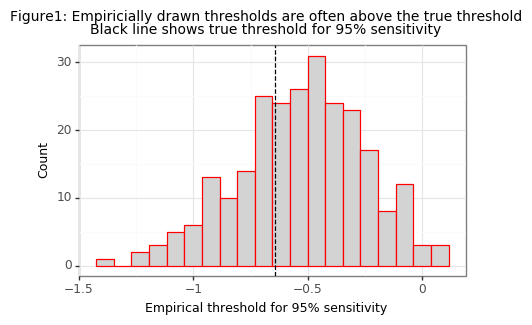

<ggplot: (8787352578905)>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import plotnine
from plotnine import *

# Assuming log-odds look normal, what is mean, sd of test-set probs?
mu_1, sd_1 = 1, 1
# Sensitivity required
k = 0.95
# How many samples in the test set
n_test_pos = 50
# Number of simulations
nsim = 250
# True 95% threshold
thresh_true = mu_1 + sd_1*stats.norm.ppf(1-k)

# Example of nsim 95% sensitivity thresholds
thresh_sim = np.array([np.quantile(stats.norm.rvs(loc=mu_1,scale=sd_1, size=n_test_pos, random_state=s),1-k) for s in range(nsim)])
tit1 = ('Figure1: Empiricially drawn thresholds are often above the true threshold\n'
        'Black line shows true threshold for 95% sensitivity')

plotnine.options.figure_size = (5,3)
gg_thresh_sim = (ggplot(pd.DataFrame({'thresh':thresh_sim}),aes(x='thresh')) + 
                 geom_histogram(fill='lightgrey',color='red',bins=20) + theme_bw() + 
                 labs(y='Count', x='Empirical threshold for 95% sensitivity') + 
                 geom_vline(xintercept=thresh_true,linetype='--') +
                 theme(title=element_text(size=10),axis_title=element_text(size=9)) + 
                 ggtitle(tit1))
gg_thresh_sim

In [39]:
# Show which metrics are "valid"
np.random.seed(1234)
n1, n0 = 50, 100
mu_0, sd_0 = -1, 2
x1, x0 = sd_1*np.random.randn(n1)+mu_1, sd_0*np.random.randn(n0)+mu_0
xx, yy = np.append(x1, x0), np.append(np.repeat(1,n1),np.repeat(0,n0))
df_metric = pd.DataFrame({'tt':xx.copy(),'sens':np.NaN,'spec':np.NaN,'prec':np.NaN,'F1':np.NaN})
for ii, tt in enumerate(xx):
    yhat = np.where(xx>tt,1,0)
    tp = np.where((yhat==1) & (yy==1),1,0)
    fp = np.where((yhat==1) & (yy==0),1,0)
    tn = np.where((yhat==0) & (yy==0),1,0)
    sens = tp[yy==1].sum()/n1
    spec = tn[yy==0].sum()/n0
    ppv = tp.sum()/(tp.sum()+fp.sum())
    f1 = 2*(ppv*sens)/(ppv+sens)
    df_metric.iloc[ii] = [tt, sens, spec, ppv,f1]
df_metric = df_metric.sort_values('tt').reset_index(None,True)
df_metric = df_metric.melt('tt',None,'metric').dropna()

/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars


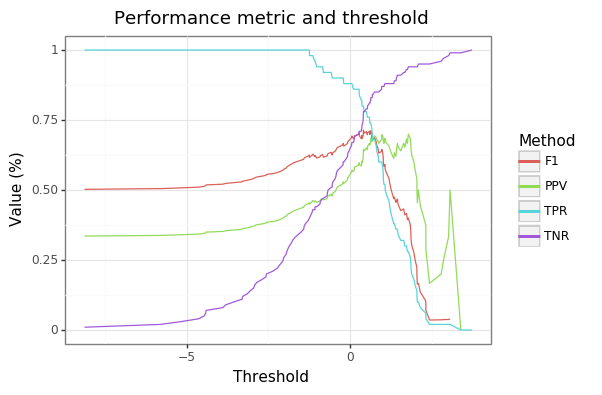

<ggplot: (8787335372733)>

In [43]:
plotnine.options.figure_size = (5.5,4)

gg_metric = (ggplot(df_metric,aes(x='tt',y='value',color='metric')) + 
            theme_bw() + 
            labs(x='Threshold',y='Value (%)') + 
            scale_color_discrete(name='Method',labels=['F1','PPV','TPR','TNR']) + 
            geom_line() + 
            ggtitle('Performance metric and threshold'))
gg_metric

Most of the time $\hat{t}_{0.95}$ would lead to long-run sensitivity of below 95%! Even if the 5th percentile were symmetric then at best $P(\hat{t} > t^*) = 0.5$

## (2) Getting $k$% sensitivity $j$% of the time

Since the intuitive approach will yield a threshold that will fail to give an asymptotic threshold target at least half of the time, a more robust method would be to select $\hat{t}$ so that it will achieve an asymptotic  sensitivity of **at least** $k\%$ for $j\%$ of the time (this is equivalent to a one-sided confidence interval). Of course picking a $t$ that is very small (e.g. $\hat{t}=\min[\hat{p}_1]-10$) will guarantee a sensivivity of at least $k\%$ close to 100% of the time, but this will yield unnessary false positives (as sensitivity increases, the false positive rate must necessarily as well). An ideal threshold estimator will have a $\hat t \leq t^*$ exactly $j\%$ of the time (no more and no less).[[^4]] This property is known as the [coverage](https://en.wikipedia.org/wiki/Coverage_probability).

In order to find this one-sided confidence interval, the distribution of $\hat t_k$ has to be known. Unfortunately there is no parametric distribution for such a statistic. Instead non-parametric methods must be used. The first (and my preferred) approach is to use the bias-corrected and accelerated (BCa) bootstrap. Even before taking the bootstrap, the distribution of $\hat t_{0.95}$ is skewed as Figure 1 shows above. Simpler bootstrapping approaches will fail both because there is a bias in the boostrapped sample (the mean of the boostrapped quantiles is larger than the empiricial quantile) and because there is a right-skew in the data. The simulations below will show that the BCa gets close to the target coverage of $j=80$%.

[^4]: Remember that when $\hat t_k < t^*_k$, the asymptotic sensitivity will be greater than $k$% and when $\hat t_k > t^*_k$ the asymptotic sensitivity will be less than $k$%.

In [ ]:
from arch.bootstrap import IIDBootstrap

# "Confidence" of sensivitiy
j = 0.80
# Number of bootstrap samples to take
nboot = 1000

seed = 1234
np.random.seed(seed)

cn_boot = ['basic','percentile','norm','bca']
holder = np.zeros([nsim, len(cn_boot)]) # Four boot
for i in range(nsim):
  # if (i + 1) % 25 == 0:    
  #   print('Iteration %i of %i' % (i+1,nsim))
  # A draw of the data from the universe of test set probabilities
  phat_1 = np.random.randn(n_test_pos)*sd_1 + mu_1
  bs = IIDBootstrap(a=phat_1) # CI for the different approaches
  lb = [bs.conf_int(func=np.quantile, reps=nboot, method=meth, size=j, tail='lower', extra_kwargs={'q':1-k})[0,0] for meth in cn_boot]
  holder[i,:] = np.array(lb)

# The Bias-Correction+Acceleration gets very close to j% coverage (when j=80%)
df_sim = pd.DataFrame(holder,columns=cn_boot).melt(None,None,'method','lb')
df_sim = df_sim.groupby('method').lb.apply(lambda x: np.mean(x <= thresh_true)).reset_index()
df_sim = df_sim.assign(error=lambda x: (x.lb - j)*100).sort_values('error',ascending=False).reset_index(None,True)
np.round(df_sim,2)

,method,lb,error
0,bca,0.78,-2.0
1,norm,0.68,-11.6
2,basic,0.65,-14.8
3,percentile,0.64,-16.0


The BCa boostrap gets a coverage of 78% for a target of 80% which is very good, especially considereing the small sample size and skewed/biased distribution of the test statistic (see example below).

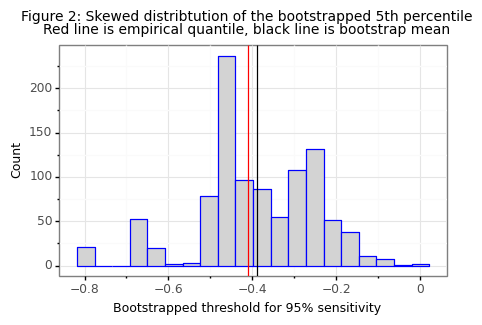

<ggplot: (-9223363288624798236)>

In [ ]:
ex_stat = bs.apply(func=np.quantile, reps=nboot, extra_kwargs={'q':1-k}).flatten()

tit2 = ('Figure 2: Skewed distribtution of the bootstrapped 5th percentile\n'
        'Red line is empirical quantile, black line is bootstrap mean')
plotnine.options.figure_size = (5,3)
gg_bs = (ggplot(pd.DataFrame({'x':ex_stat}),aes(x='x')) + 
         geom_histogram(fill='lightgrey',color='blue',bins=20) + theme_bw() + 
         labs(y='Count', x='Bootstrapped threshold for 95% sensitivity') + 
         theme(title=element_text(size=10),axis_title=element_text(size=9)) + 
         geom_vline(xintercept=np.mean(ex_stat),color='black') + 
         geom_vline(xintercept=np.quantile(phat_1, 1-k),color='red') + 
         ggtitle(tit2))
gg_bs

An alternative to the BCa bootstrap is to use Neyman-Pearson umbrella (NP-Umbrella) algorithm detailed in [*Tong et al* (2018)](https://advances.sciencemag.org/content/4/2/eaao1659). Define the Type-II error risk of a classifier $R(\psi(f)) = E[\hat \psi(f(x)) \neq y | y=1]$. This is equivalent to 1 minus the sensitivity. Next assume that the classifier uses the $r^{th}$ rank-order statistic from the distribution of positive labels: $\hat{\psi}_r=I(f_\theta(x)>\hat{p}^1_{(r)})$, where $\hat{p}^1_{(r)}$ is the r-th order statistic: $p^1_{(1)} \leq p^1_{(2)} \leq ... \leq p^1_{(n)}$. The umbrella algorithm appeals to a slight modification the CDF of rank-order stastistics:

$$
\begin{align*}
P( R(\hat{\psi}_r) > 1-k ) &\leq 1 - \sum_{l=r}^n \begin{pmatrix} n \\ r \end{pmatrix} (1-k)^l k^{n-l} = v(r) 
\end{align*}
$$

To find the rank $r$ that leads to a type-II less than $(1-j)$% of the time the goal is to find $r^* = \max_r [v(r) \leq 1-j]$. The function below shows the relationship between the sample size and the require rank needed to obtain this bound.

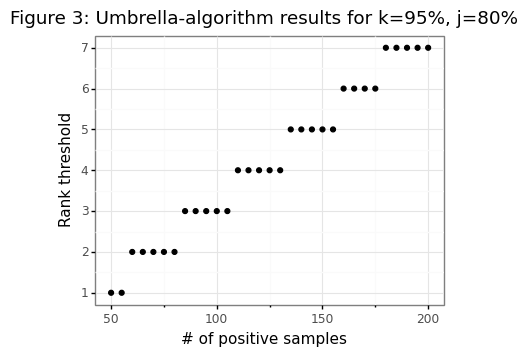

<ggplot: (-9223363288624908221)>

In [ ]:
from scipy.special import comb

def umbrella_thresh(n,k,j, ret_df=False):
  rank_seq = np.arange(n+1)
  rank_pdf = np.array([comb(n, l, True)*((1-k)**l)*((k)**(n-l)) for l in rank_seq])
  rank_cdf = np.array([rank_pdf[l:].sum() for l in rank_seq])
  res = pd.DataFrame({'rank':rank_seq, 'pdf':rank_pdf, 'cdf':rank_cdf, 'delt':1-rank_cdf})
  if ret_df:
    return res
  r_max = max(res[res.delt <= 1-j]['rank'].max(),1)
  return r_max

n_seq = np.arange(50,201,5)
r_star = np.array([umbrella_thresh(n,k,j) for n in n_seq])
df_r = pd.DataFrame({'r':r_star, 'n':n_seq})

plotnine.options.figure_size = (4.5,3.5)
gg_r = (ggplot(df_r,aes(x='n',y='r')) + geom_point() + 
        ggtitle('Figure 3: Umbrella-algorithm results for k=%i%%, j=%i%%' % (k*100,j*100)) + 
        scale_y_continuous(breaks=list(np.arange(1,8))) + 
        theme_bw() + theme(axis_ticks_minor_y=element_blank()) + 
        labs(x='# of positive samples',y='Rank threshold'))
gg_r

Notice that for 50 positive samples a rank-order of one (i.e. the minimum) is necessary to ensure that the sensitivity is at least 95%, 80% of the time. This ends up being a much tigther bound than what is actually needed. Even though the CDF is *exact*, because it is from a discrete distribution, for small sample sizes finding a value equal to exactly $(1-j)$% is impossible (i.e. there is no rank 1.5, only 1 or 2). The table below shows that for our considered sample size and sensitivity, $j$ needs to be either 92% or 72% for the NP-Umbrella to be efficient. 


In [ ]:
np.round(umbrella_thresh(n=n_test_pos, k=k, j=j, ret_df=True).head().iloc[1:],2)

,rank,pdf,cdf,delt
1,1,0.20,0.92,0.08
2,2,0.26,0.72,0.28
3,3,0.22,0.46,0.54
4,4,0.14,0.24,0.76


Figure 4 below shows, as the above table would suggest, that the NP-Umbrella gets an actual of $j$=92% using a rank-order of one as a threhold, leading to a distribution of thresholds that is too conservative. Note that even if the mean of the NP-Umbrella thresholds was shifted to the right so that $j$=80%, the variance of the thresholds would still be larger. If the code-block below is changed so that $j$=92%, the variance of the NP-Umbrella can still be shown to be larger using [Levene's test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html).

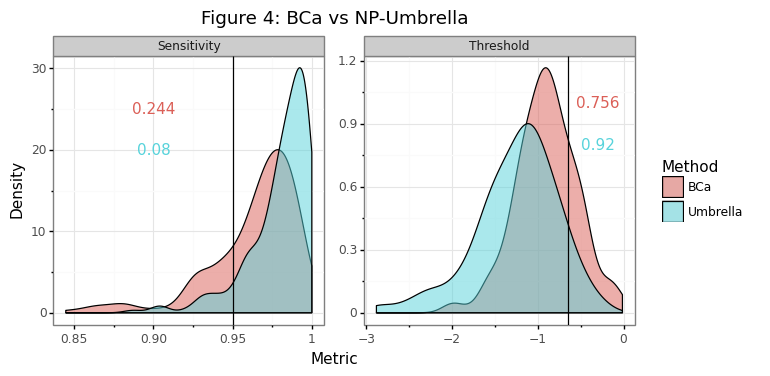

<ggplot: (8748227717110)>

In [ ]:
seed = 1234
np.random.seed(seed)

r_star = umbrella_thresh(n_test_pos, k, j)
cn_comp = ['thresh_umb','thresh_bca','sens_umb', 'sens_bca']
holder = np.zeros([nsim, len(cn_comp)]) # Four boot
for i in range(nsim):
  phat_1 = np.random.randn(n_test_pos)*sd_1 + mu_1
  thresh_umb = np.sort(phat_1)[r_star-1]
  thresh_bca = IIDBootstrap(a=phat_1).conf_int(func=np.quantile, reps=nboot, method='bca', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  sens_umb = 1-stats.norm.cdf(thresh_umb,mu_1,sd_1)
  sens_bca = 1-stats.norm.cdf(thresh_bca,mu_1,sd_1)
  holder[i,:] = np.array([thresh_umb, thresh_bca, sens_umb, sens_bca])

df_comp = pd.DataFrame(holder,columns=cn_comp).melt()
df_comp = pd.concat([pd.DataFrame(df_comp.variable.str.split('_',1,True).rename(columns={0:'metric',1:'method'})),
           df_comp[['value']]],1)

di = {'thresh':'Threshold','sens':'Sensitivity'}
df_v = pd.DataFrame({'metric':['thresh','sens'],'value':[thresh_true,0.95]})
df_j = df_comp.merge(df_v,'left','metric',suffixes=('','_true')).groupby(['metric','method'])
df_j = df_j.apply(lambda x: np.mean(x.value < x.value_true)).reset_index().rename(columns={0:'rate'})
df_j = df_j.assign(x=[0.9,0.9,-0.3,-0.3],y=[25,20,1.0,0.8])
plotnine.options.figure_size=(7.5,3.5)
gg_comp = (ggplot(df_comp,aes(x='value',fill='method')) + 
           geom_density(alpha=0.5,color='black') + 
           labs(y='Density',x='Metric') + 
           facet_wrap('~metric',labeller=labeller(metric=di),scales='free') + 
           theme_bw() + theme(panel_spacing_x=0.4) + 
           geom_text(aes(x='x',y='y',label='rate',color='method'),data=df_j) + 
           geom_vline(aes(xintercept='value'),df_v) + 
           guides(color=False) + 
           ggtitle('Figure 4: BCa vs NP-Umbrella') + 
           scale_fill_discrete(name='Method',labels=['BCa','Umbrella']))
gg_comp

In summary picking a threshold is difficult because $\psi_t(\hat p_1)$ is what is observed from some random sample $\hat x$ whereas the distribution of $\psi_t(p_1)$ for all $x$ is needed to establish an asymptotically valid threshold. This fundamental uncertainty leads to a choice of $\hat t$ that is conservative so that the threshold statistic can obtain a targeted asymptotic sensitivity $j$% of the time. The BCa boostrap does a good job at this and has a more exact confidence bound than the NP-Umbrella for smaller-sized samples as well as being more efficient.

## (3) Finding the sample size to reject $k_0 \leq k$

The final stage of designing an evaluation trial for a machine learning algorithm is similar to a standard clinical trial: sample-size justifications based on a power analysis. Sections (1) and (2) showed how to pick a threshold $\hat t$ that will obtain a sensitivity bound with high probability. Now assume that the model possesses an aymptotic sensitivity of $k$%. To establish statistical significance a null hypothesis of the form $H_0: k_0 \leq l$  in favour of $H_A: k_0 > l$. Unfortunately $l$ cannot be set to $k$, because the null would not be rejected as the number of samples increased because the null would be true! Could the failure to reject the null be considered evidence in favour of the hypothesis? Unfortunately not not rejecting can be caused by either a lack of samples or a true null.

By setting $l=k-b < k$ then a sufficient number of samples will lead to a rejection of the null.[[^2]] As the $b$% buffer grows the null hypothesis becomes easier to reject, but the uncertainty around how close the model is to its desired performance level will increase. Ideally $b \to 0$, but this would require $n \to \infty$. There is no free lunch! 

Because sensitivity is a binomial propotion, its distributional form can be [approximated](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval). If $\hat s$ is the observed sensitivity of the trial, then the statistic $s_0$ has a normal distribution unde the null:

$$
s_0 = \frac{\hat{s} - l}{\sqrt{\frac{l(1-l)}{n}}} = \frac{\hat{s} - l}{\sigma_l} \sim N(0,1)
$$

If the trial will reject a null hypothesis at the $(1-\alpha)$% level, then it is easy to determine the critical value at which $s_0$ will be rejected.

$$
s^*_0(\alpha) = l + \sigma_l \cdot \Phi^{-1}(1-\alpha) 
$$

Since $l$ was chosen to be less than $k$, the observed statistic will actually come from its distribution under the alternative hypothesis.

$$
s_A = \frac{\hat{s} - k}{\sigma_k} \sim N(0,1)
$$

To carry out a power analysis it is sufficient to see how many observations are necessary for $s_A$ to reject the null $(1-\beta)$% of the time (i.e. when $\hat s$ is greater than the critical value $s_0^*(\alpha)$).

$$
\begin{align*}
\hat{s} &> l + \sigma_l \cdot \Phi^{-1}_\alpha \\
\frac{\hat{s}-k}{\sigma_k} &> \frac{(l-k) + \sigma_l \cdot \Phi^{-1}_{1-\alpha}}{\sigma_k} \sim N(0, 1) \\
s_A &> \sqrt{n} \cdot\frac{(l-k)}{\sqrt{k(1-k)}} + \sqrt{\frac{l(1-l)}{k(1-k)}} \Phi^{-1}_{1-\alpha}
\end{align*}
$$

If $s_A^* = \Phi^{-1}(\beta)$, then $s_A > s_A^*$ $(1-\beta)$% of the time. Plugging this into the above formula yields:

$$
\begin{align*}
n^* &= \inf_n \hspace{2mm} \{ s_A(n) \geq \Phi^{-1}_\beta \} \\
n^* &= \Bigg[ \frac{\sqrt{k(k-k)}\Phi^{-1}_\beta - \sqrt{l(1-l)}\Phi^{-1}_{1-\alpha}}{l-k} \Bigg]^2
\end{align*}
$$

The plots below will show how different levels of $k$, $b$, and $\beta$ lead to different requirements for $n^*$.

[^2]: At this point it must be assumed that the threshold is less than equal to the true asymptotic threshold.

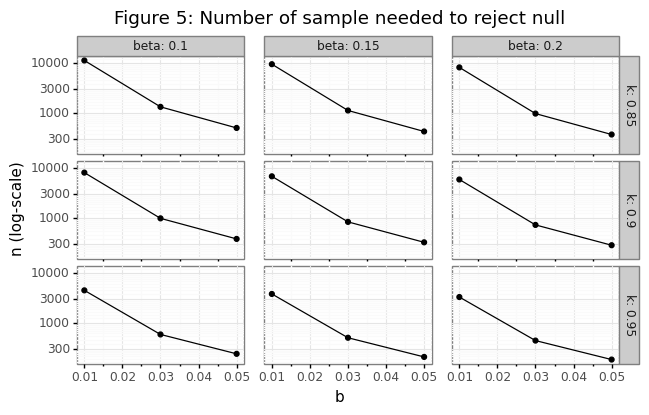

<ggplot: (8787008619745)>

In [67]:
def n_star(k, b, beta, alpha):
  assert (b > 0) & (b < k)
  l = k - b
  term1 = np.sqrt(k*(1-k))*stats.norm.ppf(beta)
  term2 = np.sqrt(l*(1-l))*stats.norm.ppf(1-alpha)
  term3 = l - k 
  stat = ((term1 - term2)/term3)**2
  return stat

k_seq = [0.85, 0.90, 0.95]
b_seq = [0.01, 0.03, 0.05]
beta_seq = [0.10, 0.15, 0.20]
params = np.array(np.meshgrid(k_seq, b_seq, beta_seq)).T.reshape(-1,3)
params = pd.DataFrame(params,columns=['k','b','beta'])
params.insert(0,'n',params.apply(lambda x: n_star(x.k, x.b, x.beta, 0.05),1))

plotnine.options.figure_size = (7,4)
gg_n = (ggplot(params, aes(x='b',y='n')) + 
        geom_point() + geom_line() + theme_bw() + 
        scale_y_log10() + 
        labs(y='n (log-scale)') + 
        ggtitle('Figure 5: Number of sample needed to reject null') +
        facet_grid('k~beta', labeller=label_both) + 
        theme(panel_spacing_x=0.2, axis_ticks_minor_y=element_blank()))
gg_n

Figure 5 shows three stylized facts. First, increasing $k$ makes it easier to reject the null. This is because it's easier to distinguish the difference between a sensitivity of 99% and 98% compared to 51% and 50%. Second, and obviously, lowering $\beta$ increases the number of samples needed. The third and most important factor is $b$. Increasing $b$ from 1% to 5% can lead to a decrease in the number of samples by a factor of 30! 

The implications of this are that high sensitivity targets are difficult to prove because if $k-l$=95%, then $k$=100! Just as central banks can hit the [zero lower bound](https://en.wikipedia.org/wiki/Zero_lower_bound) when setting interest rate policies, there are some thresholds that cannot be establish if the nomial level is too high. Note that the sample-size formula $n^*$ is based on a normal approximation of a binomial propotion. The simulation below shows that this approximation is yields an estimate predicted power that is within 2% of the actual power target.

In [68]:
np.random.seed(1234)  # For reproducability

nsim = 5000
power_sim = []
for jj, rr in params.iterrows():
  n, k, b, beta = int(np.ceil(rr['n'])), rr['k'], rr['b'], rr['beta']
  l = k - b
  holder = []
  for ii in range(nsim):
    # Realized sensitivity
    s_hat = np.random.binomial(n, k) / n
    # Statistic under the null
    sd_l = np.sqrt(l*(1-l)/n)
    s_0 = (s_hat - l)/sd_l
    pval = 1-stats.norm.cdf(s_0)
    holder.append(pval)
  beta_hat = 1-np.mean(np.array(holder) < 0.05)
  rr_2 = rr.append(pd.Series({'beta_hat':beta_hat}))
  power_sim.append(rr_2)
power_res = pd.concat(power_sim,1).T

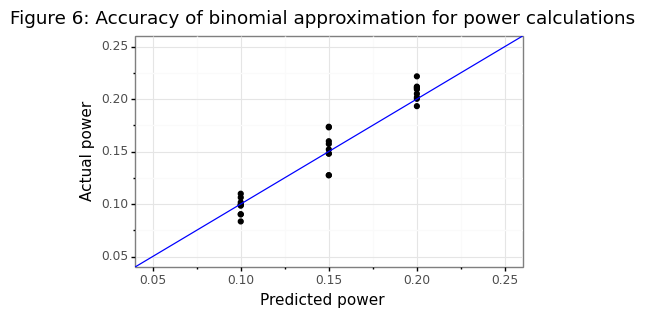

<ggplot: (-9223363249853465358)>

In [69]:
plotnine.options.figure_size = (5,3)
yt = list(np.arange(0.05, 0.251, 0.05))
gg_power = (ggplot(power_res, aes(x='beta',y='beta_hat')) + 
            geom_point() + theme_bw() + 
            geom_abline(slope=1,intercept=0,color='blue') + 
            scale_y_continuous(breaks=yt, limits=(0.05,0.25)) + 
            scale_x_continuous(breaks=yt, limits=(0.05,0.25)) + 
            labs(x='Predicted power',y='Actual power') + 
            ggtitle('Figure 6: Accuracy of binomial approximation for power calculations'))
gg_power

## (4) Applied example

To conclude the post we will use the tools discussed in sections (1)-(3) to design and evaluate how well the threshold and sample size calculations works for a specific example. Assume the algorithm has a target sensitivity of 95%, the null hypothesis is set to 90% with a 5% type-I error rate. The desired power is 80%. The threshold is going to be generated based on 50 positive test set samples with 80% confidence. The `n_star` function tells us that a total of 184 positive class patients will be needed to reject the null 80% of the time.

In [101]:
k, l, alpha, beta, j = 0.95, 0.90, 0.05, 1-0.8, 0.8
b = k - l
n_study = int(np.ceil(n_star(k,b,beta,alpha)))
print('We need %i samples for the study' % n_study)

np.random.seed(1234)

nsim = 1000
holder = np.zeros([nsim, 2])
for i in range(nsim):
  # A draw of the data from the universe of test sets
  phat_1_test = np.random.randn(n_test_pos)*sd_1 + mu_1
  # Get the confidence interval for the threshold
  bs = IIDBootstrap(a=phat_1_test)
  threshold = bs.conf_int(func=np.quantile, reps=nboot, method='bca', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  # A draw of the data on the trial dataset
  phat_1_trial = np.random.randn(n_study)*sd_1 + mu_1
  # Testing
  sens_trial = np.mean(phat_1_trial > threshold)
  stat_trial = (sens_trial - l) / np.sqrt(l*(1-l) / n_study)
  pval_trial = 1-stats.norm.cdf(stat_trial)
  holder[i] = np.array([sens_trial, pval_trial])

df_trial = pd.DataFrame(holder,columns=['sens','pval'])
print('Reject the null %0.1f%% of the time\nAverage sensitivity: %0.1f%%' % 
      (np.mean(df_trial.pval<alpha)*100, df_trial.sens.mean()*100))

We need 184 samples for the study
Reject the null 83.5% of the time
Average sensitivity: 96.4%


The threshold obtained by the bootstrapping method obtains an average sensitivity of 96.4%, just slightly higher than the targeted level of 95%, highlighting the importance of using the lower-bound on the threshold to ensure a slightly conservative measure. The study was slightly overpowered as the null is rejected 83.5% of the time. This overshoot is due to a combination of the normal approximation error in the binomial proportion statistic as well as the the conservatism in the threshold. Nevertheless it is better to be over- rather than under-powered when designing a trial to validate an important algorithm that could have significant effect on a patient population.

This post has explained what the main statistical challenges are for validating a binary classifier in a statistical trial and the two-step process needed to 1) find an appropriate threshold, and 2) find an appropriate sample size. As machine learning models become used in more domains, having a rigorous statistical procedure for their adoption will become increasingly important.